# Step 1 : importing Essential Libraries

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(123)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import itertools

import keras
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K
import itertools
from keras.layers.normalization import BatchNormalization
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding

from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [44]:
#1. Function to plot model's validation loss and validation recall
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for recall
    axs[0].plot(range(1,len(model_history.history['recall_1'])+1),model_history.history['recall_1'])
    axs[0].plot(range(1,len(model_history.history['val_recall_1'])+1),model_history.history['val_recall_1'])
    axs[0].set_title('Model Recall')
    axs[0].set_ylabel('Recall')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['recall_1'])+1),len(model_history.history['recall_1'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()


# Step 2 : Making Dictionary of images and labels
We make the image path dictionary by joining the folder path from base directory base_skin_dir and merge the images in jpg format from both the folders HAM10000_images_part_1 and HAM10000_images_part_2

In [3]:
base_skin_dir = os.path.join('data')

# Merge images from both folders HAM10000_images_part_1 and HAM10000_images_part_2 into one dictionary
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

# Dictionary with more human-friendly labels
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

# Step 3 : Reading & Processing data

We read the csv by joining the path of image folder which is the base folder where all the images are placed named base_skin_dir

After that we make some new columns which is easily understood for later reference such as we have made column path which contains the image_id, cell_type which contains the short name of lesion type and at last we make the categorical column cell_type_idx in which we have categorize the lesion type

In [4]:
skin_df = pd.read_csv(os.path.join(base_skin_dir, 'HAM10000_metadata.csv'))

# Create new columns for better readability
skin_df['path'] = skin_df['image_id'].map(imageid_path_dict.get)
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get) 
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes

In [5]:
# Printing a sample of the data
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,data/HAM10000_images_part_1/ISIC_0027419.jpg,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,data/HAM10000_images_part_1/ISIC_0025030.jpg,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,data/HAM10000_images_part_1/ISIC_0026769.jpg,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,data/HAM10000_images_part_1/ISIC_0025661.jpg,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,data/HAM10000_images_part_2/ISIC_0031633.jpg,Benign keratosis-like lesions,2


# Step 4 : Data Cleaning
We check for Missing values and datatype of each field 

In [6]:
skin_df.isnull().sum()

lesion_id         0
image_id          0
dx                0
dx_type           0
age              57
sex               0
localization      0
path              0
cell_type         0
cell_type_idx     0
dtype: int64

As it is evident from the above that only age has null values which is 57 so we will fill the null values by their mean.

In [7]:
skin_df['age'].fillna((skin_df['age'].mean()), inplace=True)

Now, lets check the presence of null values  again

In [8]:
skin_df.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age              0
sex              0
localization     0
path             0
cell_type        0
cell_type_idx    0
dtype: int64

In [9]:
print(skin_df.dtypes)

lesion_id         object
image_id          object
dx                object
dx_type           object
age              float64
sex               object
localization      object
path              object
cell_type         object
cell_type_idx       int8
dtype: object


# Step 5 : EDA (Exploratory Data Analysis)
We explore different features of the dataset, their distrubtions and actual counts

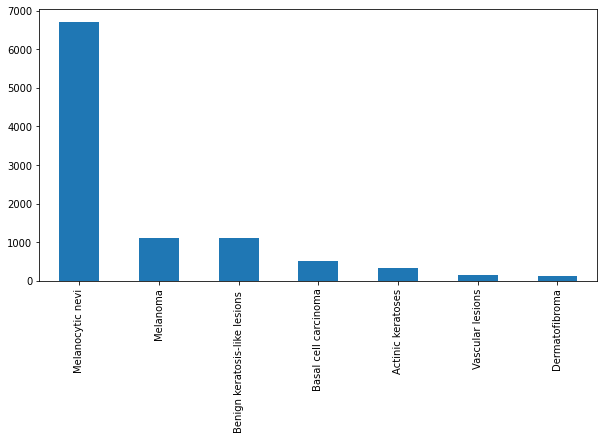

In [10]:
# Plot to see distribution of 7 different classes of cell type
fig, ax1 = plt.subplots(1, 1, figsize= (10, 5))
skin_df['cell_type'].value_counts().plot(kind='bar', ax=ax1)

Its seems from the above plot that in this dataset cell type Melanecytic nevi has very large number of instances in comparison to other cell types. That is why we decided to use a recall as a metric, not accuracy.

We check the distribution of Age

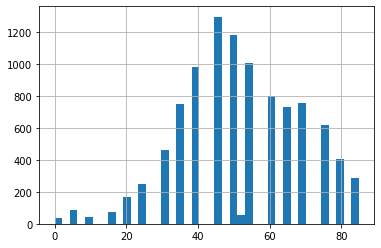

In [12]:
skin_df['age'].hist(bins=40)

It seems that there are larger instances of patients having age from 30 to 60

Lets see the distribution of males and females

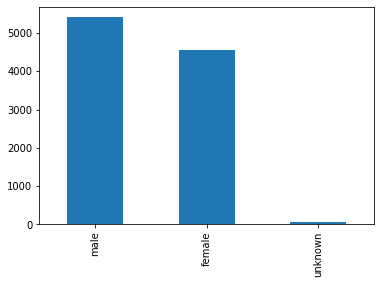

In [13]:
skin_df['sex'].value_counts().plot(kind='bar')

# Step 6: Loading and resizing of images
We load images into the column named image from the image path from the image folder. We also resize the images as the original dimension of images are 450 x 600 x3 which TensorFlow can't handle, so that's why we resize it into 100 x 75

In [14]:
skin_df['image'] = skin_df['path'].map(lambda x: np.asarray(Image.open(x).resize((100,75))))

In [15]:
# Printing a sample of the data
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,image
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,data/HAM10000_images_part_1/ISIC_0027419.jpg,Benign keratosis-like lesions,2,"[[[190, 153, 194], [192, 154, 196], [191, 153,..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,data/HAM10000_images_part_1/ISIC_0025030.jpg,Benign keratosis-like lesions,2,"[[[23, 13, 22], [24, 14, 24], [25, 14, 28], [3..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,data/HAM10000_images_part_1/ISIC_0026769.jpg,Benign keratosis-like lesions,2,"[[[185, 127, 137], [189, 133, 147], [194, 136,..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,data/HAM10000_images_part_1/ISIC_0025661.jpg,Benign keratosis-like lesions,2,"[[[24, 11, 17], [26, 13, 22], [38, 21, 32], [5..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,data/HAM10000_images_part_2/ISIC_0031633.jpg,Benign keratosis-like lesions,2,"[[[134, 90, 113], [147, 102, 125], [159, 115, ..."


We plot the images to see the data

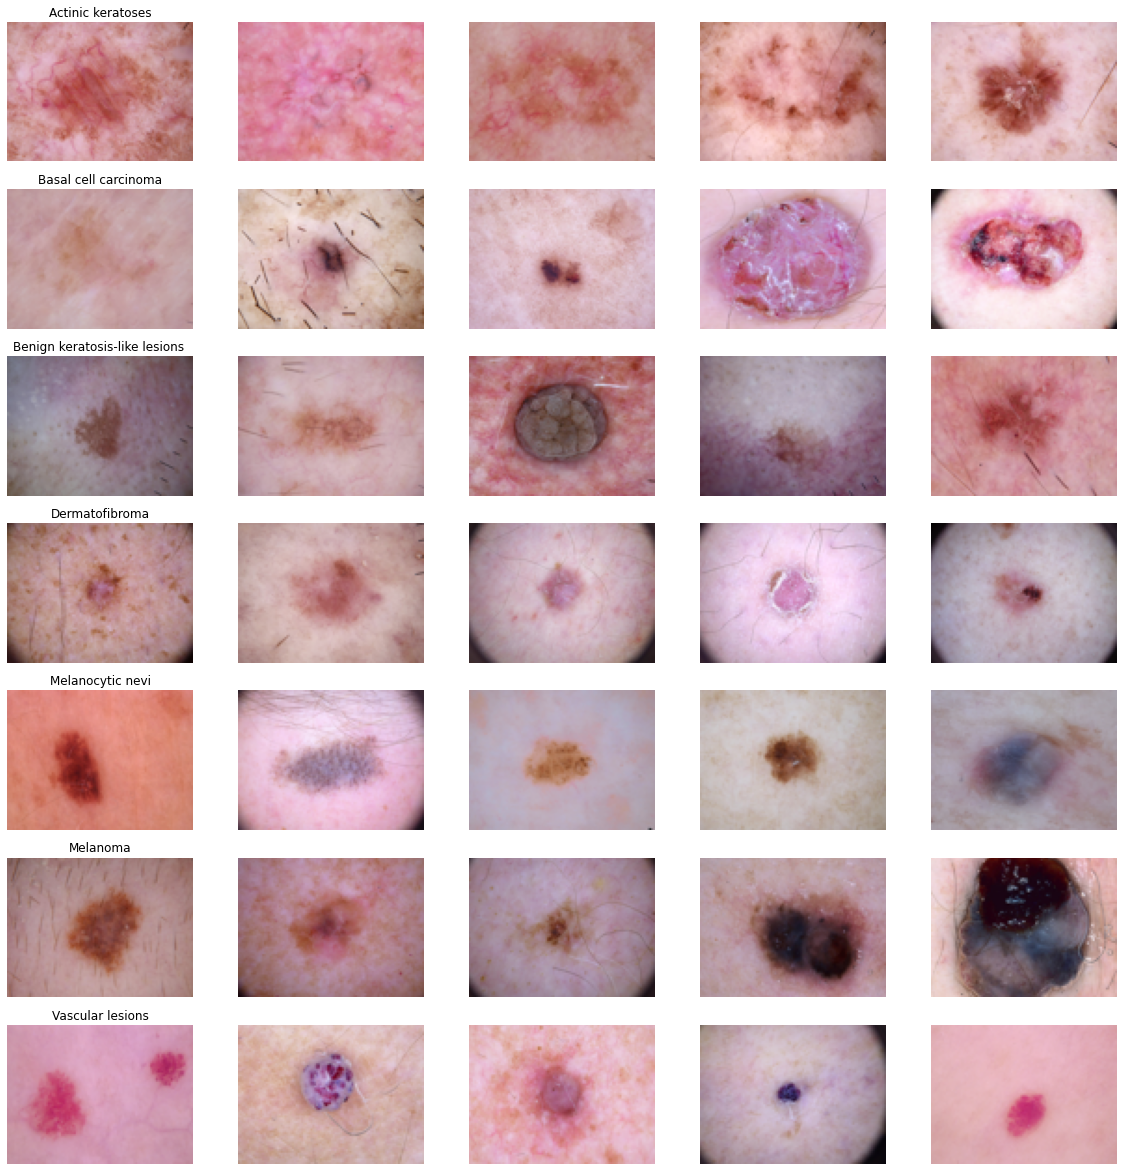

In [16]:
n_samples = 5
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         skin_df.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
fig.savefig('category_samples.png', dpi=300)

In [17]:
# Check the image size distribution
skin_df['image'].map(lambda x: x.shape).value_counts()

(75, 100, 3)    10015
Name: image, dtype: int64

In [18]:
features=skin_df.drop(columns=['cell_type_idx'],axis=1)
target=skin_df['cell_type_idx']

# Step 7 : Train Test Split
We split the dataset into training and testing set of 80:20 ratio

In [19]:
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(features, target, test_size = 0.2, random_state = 123)

# Step 8 : Normalization

We choose to normalize the x_train, x_test by substracting from theor mean values and then dividing by thier standard deviation.

In [20]:
x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

# Step 9 : Label Encoding
Labels are 7 different classes of skin cancer types from 0 to 6. We need to encode these lables to one hot vectors

In [21]:
# Perform one-hot encoding on the labels
y_train = to_categorical(y_train_o, num_classes = 7)
y_test = to_categorical(y_test_o, num_classes = 7)

# Step 10 : Splitting training and validation split

We choose to split the train set in two parts : a small fraction (10%) became the validation set which the model is evaluated and the rest (90%) is used to train the model

In [22]:
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1, random_state = 123)

In [23]:
# Reshape image in 3 dimensions (height = 75px, width = 100px , canal = 3)
x_train = x_train.reshape(x_train.shape[0], *(75, 100, 3))
x_test = x_test.reshape(x_test.shape[0], *(75, 100, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(75, 100, 3))

# Step 11: Model Building 

## CNN

We use  the Keras Sequential API

In [24]:
# Set the CNN model 
# CNN architechture is In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out
input_shape = (75, 100, 3)
num_classes = 7

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding = 'Same',input_shape=input_shape))
model.add(Conv2D(32,kernel_size=(3, 3), activation='relu',padding = 'Same',))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.40))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 75, 100, 32)       896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 100, 32)       9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 50, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 37, 50, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 37, 50, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 37, 50, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 25, 64)       

# Step 12: Setting Optimizer and Metrics

Adam is a popular algorithm in the field of deep learning because it achieves good results fast

In [25]:
# Define the optimizer
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, decay=0.0, amsgrad=False)

In [34]:
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=[keras.metrics.Recall()])

In [35]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

# Data Augmentation

In order to avoid overfitting problem, we expand artificially our HAM 10000 dataset. The idea is to alter the training data with small transformations to reproduce the variations 

In [36]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(x_train)

# Step 13: Fitting the model

We fit the model into x_train, y_train. In this step I have choosen batch size of 10 and 30 epochs

In [37]:
# Fit the model
epochs = 30 
batch_size = 10
history = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_validate,y_validate),
                              verbose = 1, steps_per_epoch=x_train.shape[0]//batch_size, 
                              callbacks=[learning_rate_reduction])

Epoch 1/30
721/721 [==============================] - 134s 185ms/step - loss: 1.0153 - recall_1: 0.5255 - val_loss: 0.9332 - val_recall_1: 0.5686
Epoch 2/30
721/721 [==============================] - 130s 180ms/step - loss: 0.9190 - recall_1: 0.5592 - val_loss: 0.8648 - val_recall_1: 0.6259
Epoch 3/30
721/721 [==============================] - 135s 187ms/step - loss: 0.8958 - recall_1: 0.5684 - val_loss: 0.8389 - val_recall_1: 0.5773
Epoch 4/30
721/721 [==============================] - 130s 180ms/step - loss: 0.8587 - recall_1: 0.5802 - val_loss: 0.8245 - val_recall_1: 0.5960
Epoch 5/30
721/721 [==============================] - 131s 182ms/step - loss: 0.8293 - recall_1: 0.5890 - val_loss: 0.7781 - val_recall_1: 0.5810
Epoch 6/30
721/721 [==============================] - 131s 182ms/step - loss: 0.8164 - recall_1: 0.5893 - val_loss: 0.7488 - val_recall_1: 0.5860
Epoch 7/30
721/721 [==============================] - 132s 183ms/step - loss: 0.8017 - recall_1: 0.6054 - val_loss: 0.7513 -

# Step 14: Model Evaluation 

We check the testing recall and validation recall of our model and plot which category has much incorrect predictions

In [46]:
loss, recall = model.evaluate(x_test, y_test, verbose=1)
loss_v, recall_v = model.evaluate(x_validate, y_validate, verbose=1)
print("Validation: recall = %f  ;  loss_v = %f" % (recall_v, loss_v))
print("Test: recall = %f  ;  loss = %f" % (recall, loss))
model.save("model.h5")

802/802 [==============================] - 2s 3ms/step
Validation: recall = 0.709476  ;  loss_v = 0.655374
Test: recall = 0.686470  ;  loss = 0.667912


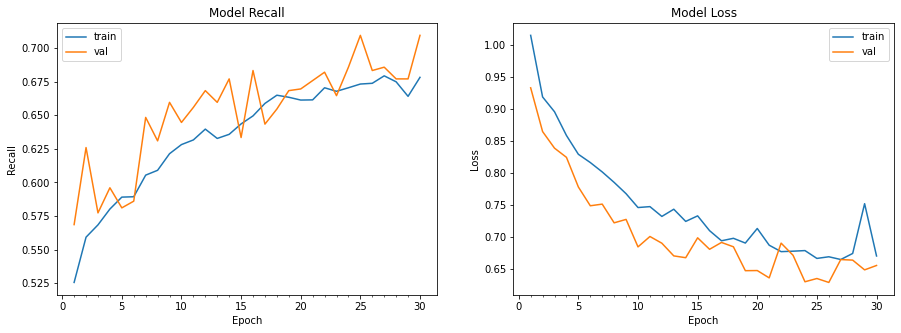

In [45]:
plot_model_history(history)